# 전체 데이터셋을 임의로 200 명이 포함된 Training dataset 과 103 명 Validation dataset 으로 구분한 뒤 다음 각 물음에 답하시오. 분류 성능을 평가/비교할 때는 TPR, TNR, Precision, Accuracy, BCR, F1- Measure 를 모두 고려하여 의견을 서술하시오. 

In [96]:
# Performance Evaluation Function
perf_eval <- function(cm){
  
  # True positive rate: TPR (Recall)
  TPR <- cm[2,2]/sum(cm[2,])
  # Precision
  PRE <- cm[2,2]/sum(cm[,2])
  # True negative rate: TNR
  TNR <- cm[1,1]/sum(cm[1,])
  # Simple Accuracy
  ACC <- (cm[1,1]+cm[2,2])/sum(cm)
  # Balanced Correction Rate
  BCR <- sqrt(TPR*TNR)
  # F1-Measure
  F1 <- 2*TPR*PRE/(TPR+PRE)
  
  return(c(TPR, PRE, TNR, ACC, BCR, F1))
}

# Performance table
Perf_Table <- matrix(0, nrow = 3, ncol = 6)
rownames(Perf_Table) <- c("CART(pruned(x))","CART(pruned(post))","CART(pruned(pre))")
colnames(Perf_Table) <- c("TPR", "Precision", "TNR", "Accuracy", "BCR", "F1-Measure")

In [97]:
# Load the data & Preprocessing
df <- read.csv("heart.csv")
input_idx <- c(1:13)
target_idx <- 14

df_input <- df[,input_idx]
df_target <- as.factor(df[,target_idx])

df_data <- data.frame(df_input, df_target)

In [98]:
nR <- nrow(df)
nR

[1] 303

In [99]:
set.seed(42) #랜덤 시드 지정
trn_idx <- sample(1:nR, 200) #train data 200개 sampling
train <- data.frame(df_input[trn_idx,], HeartYN = df_target[trn_idx])
test <- data.frame(df_input[-trn_idx,], HeartYN = df_target[-trn_idx])

# [Q1] 실습 시간에 사용한 "tree”package를 사용하여 ClassificationTree를 학습한 결과물을 Plotting하고 이에 대한 해석을 수행하시오. 또한 해당 Tree 를 pruning 을 수행하지 않은 상태에서 Validation dataset 에 대한 분류 성능을 평가하시오. 

In [100]:
install.packages("tree")
library(tree)

Warning message:
"package 'tree' is in use and will not be installed"


In [101]:
# Training the tree
CART_model <- tree(HeartYN ~ ., train)
summary(CART_model)


Classification tree:
tree(formula = HeartYN ~ ., data = train)
Variables actually used in tree construction:
 [1] "cp"      "ca"      "thal"    "exang"   "thalach" "oldpeak" "sex"    
 [8] "age"     "slope"   "chol"   
Number of terminal nodes:  17 
Residual mean deviance:  0.4361 = 79.81 / 183 
Misclassification error rate: 0.1 = 20 / 200 

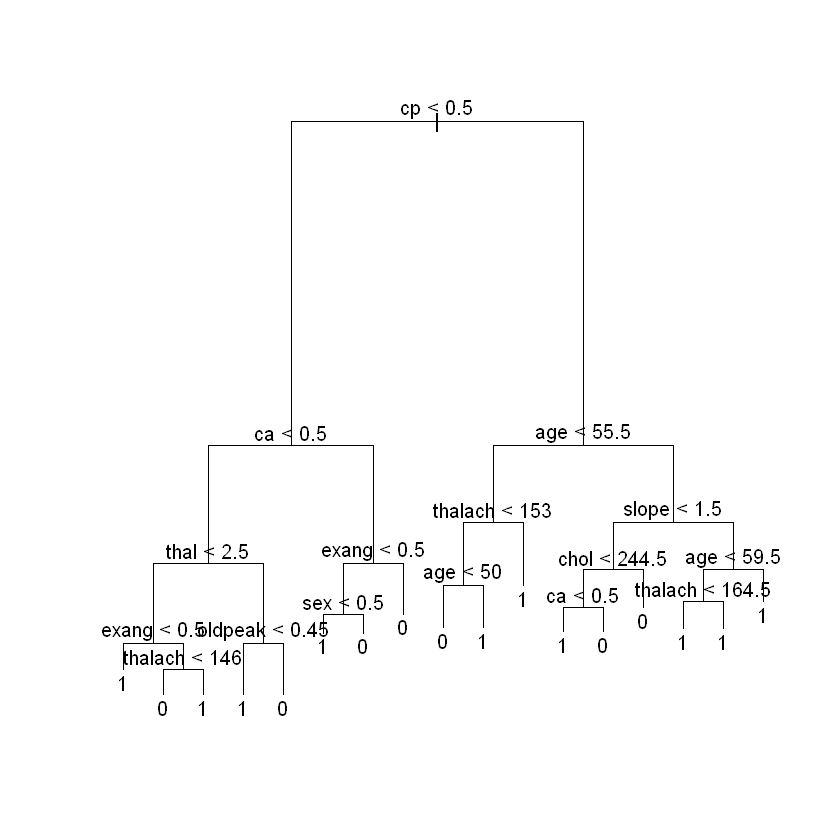

In [102]:
# Plot the tree
plot(CART_model) 
text(CART_model, pretty = 1)

In [103]:
# Prediction
CART_prey <- predict(CART_model, test, type = "class")
CART_cfm <- table(test$HeartYN, CART_prey)
CART_cfm

   CART_prey
     0  1
  0 37 12
  1  9 45

In [104]:
# Evaluation
Perf_Table[1,] <- perf_eval(CART_cfm)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
CART(pruned(x)),0.8333333,0.7894737,0.755102,0.7961165,0.7932539,0.8108108
CART(pruned(post)),0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000
CART(pruned(pre)),0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000


# [Q2] 앞에서 생성한 Tree에 대해서 적절한 Pruning을 수행한 뒤 결과물을 Plotting하고 이에 대한 해석을 수행하시오. Pruning 전과 후에 Split에 사용된 변수는 어떤 변화가 있는가? Validation dataset에 대한 분류 성능을 평가하고 [Q1]의 결과와 비교해보시오. 

In [105]:
# Find the best tree
set.seed(42)
CART_model_cv <- cv.tree(CART_model, FUN = prune.misclass)

$size
[1] 17 13 11 10  8  7  4  2  1

$dev
[1] 50 51 45 41 40 41 40 47 89

$k
[1]      -Inf  0.000000  0.500000  1.000000  1.500000  2.000000  2.333333
[8]  6.000000 43.000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

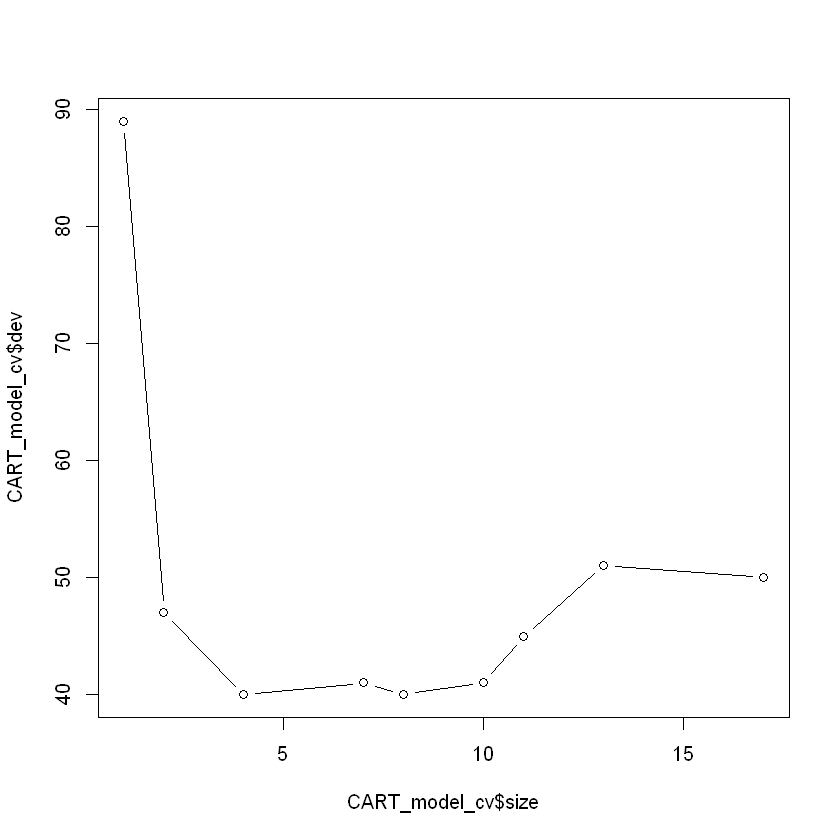

In [106]:
# Plot the pruning result
plot(CART_model_cv$size, CART_model_cv$dev, type = "b")
CART_model_cv #best model 찾기

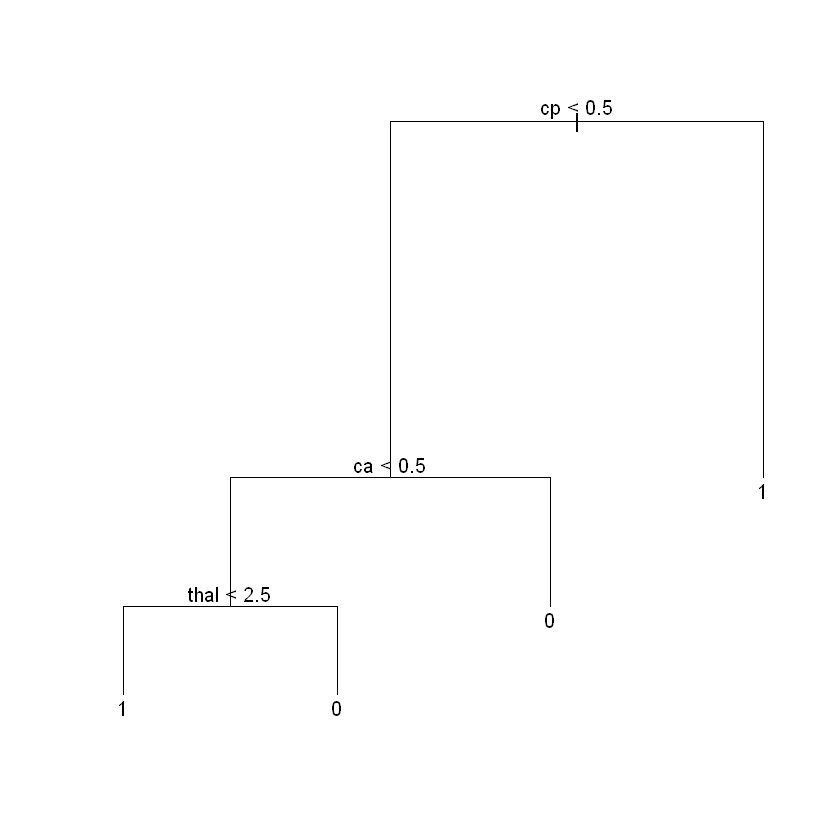

In [107]:
# Select the final model
CART_model_pruned <- prune.misclass(CART_model, best = 4)
plot(CART_model_pruned) 
text(CART_model_pruned, pretty = 1)

In [108]:
# Prediction
CART_prey <- predict(CART_model_pruned, test, type = "class")
CART_cfm <- table(test$HeartYN, CART_prey)
CART_cfm

   CART_prey
     0  1
  0 33 16
  1  3 51

In [109]:
Perf_Table[2,] <- perf_eval(CART_cfm)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
CART(pruned(x)),0.8333333,0.7894737,0.7551020,0.7961165,0.7932539,0.8108108
CART(pruned(post)),0.9444444,0.7611940,0.6734694,0.8155340,0.7975302,0.8429752
CART(pruned(pre)),0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [110]:
# CART with Post-Pruning -------------------------------
# For CART
install.packages("party")
library(party)

Warning message:
"package 'party' is in use and will not be installed"


In [111]:
# For AUROC
install.packages("ROCR")
library(ROCR)

Warning message:
"package 'ROCR' is in use and will not be installed"


In [112]:
# Divide the dataset into training/validation/test datasets
CART_trn <- train[1:120,]
CART_val <- train[121:200,]

In [113]:
min_criterion = c(0.5, 0.7, 0.9)  # 통계적 의미로 했을때 허용을 해주는 의미
min_split = c(3, 5, 10, 15) # 대상으로하고 있는 영역에 관측치의 개수가 min_split이상이어야 사용
max_depth = c(1, 3, 5) # 전체 트리의 max depth
CART_pre_search_result = matrix(0,length(min_criterion)*length(min_split)*length(max_depth),11)
colnames(CART_pre_search_result) <- c("min_criterion", "min_split", "max_depth", 
                           "TPR", "Precision", "TNR", "ACC", "BCR", "F1", "AUROC", "N_leaves")

In [114]:
iter_cnt = 1

for (i in 1:length(min_criterion)){
  for ( j in 1:length(min_split)){
    for ( k in 1:length(max_depth)){
      
      cat("CART Min criterion:", min_criterion[i], ", Min split:", min_split[j], ", Max depth:", max_depth[k], "\n")
      tmp_control = ctree_control(mincriterion = min_criterion[i], minsplit = min_split[j], maxdepth = max_depth[k])
      tmp_tree <- ctree(HeartYN ~ ., data = CART_trn, controls = tmp_control)
      tmp_tree_val_prediction <- predict(tmp_tree, newdata = CART_val)
      tmp_tree_val_response <- treeresponse(tmp_tree, newdata = CART_val)
      tmp_tree_val_prob <- 1-unlist(tmp_tree_val_response, use.names=F)[seq(1,nrow(CART_val)*2,2)]
      tmp_tree_val_rocr <- prediction(tmp_tree_val_prob, CART_val$HeartYN)
      # Confusion matrix for the validation dataset
      tmp_tree_val_cm <- table(CART_val$HeartYN, tmp_tree_val_prediction)
      
      # parameters
      CART_pre_search_result[iter_cnt,1] = min_criterion[i]
      CART_pre_search_result[iter_cnt,2] = min_split[j]
      CART_pre_search_result[iter_cnt,3] = max_depth[k]
      # Performances from the confusion matrix
      CART_pre_search_result[iter_cnt,4:9] = perf_eval(tmp_tree_val_cm)
      # AUROC
      CART_pre_search_result[iter_cnt,10] = unlist(performance(tmp_tree_val_rocr, "auc")@y.values)
      # Number of leaf nodes
      CART_pre_search_result[iter_cnt,11] = length(nodes(tmp_tree, unique(where(tmp_tree))))
      iter_cnt = iter_cnt + 1
    }
  }
}

CART Min criterion: 0.5 , Min split: 3 , Max depth: 1 
CART Min criterion: 0.5 , Min split: 3 , Max depth: 3 
CART Min criterion: 0.5 , Min split: 3 , Max depth: 5 
CART Min criterion: 0.5 , Min split: 5 , Max depth: 1 
CART Min criterion: 0.5 , Min split: 5 , Max depth: 3 
CART Min criterion: 0.5 , Min split: 5 , Max depth: 5 
CART Min criterion: 0.5 , Min split: 10 , Max depth: 1 
CART Min criterion: 0.5 , Min split: 10 , Max depth: 3 
CART Min criterion: 0.5 , Min split: 10 , Max depth: 5 
CART Min criterion: 0.5 , Min split: 15 , Max depth: 1 
CART Min criterion: 0.5 , Min split: 15 , Max depth: 3 
CART Min criterion: 0.5 , Min split: 15 , Max depth: 5 
CART Min criterion: 0.7 , Min split: 3 , Max depth: 1 
CART Min criterion: 0.7 , Min split: 3 , Max depth: 3 
CART Min criterion: 0.7 , Min split: 3 , Max depth: 5 
CART Min criterion: 0.7 , Min split: 5 , Max depth: 1 
CART Min criterion: 0.7 , Min split: 5 , Max depth: 3 
CART Min criterion: 0.7 , Min split: 5 , Max depth: 5 
CART

In [115]:
CART_pre_search_result <- CART_pre_search_result[order(CART_pre_search_result[,10], decreasing = T),]
CART_pre_search_result
best_criterion <- CART_pre_search_result[1,1]
best_split <- CART_pre_search_result[1,2]
best_depth <- CART_pre_search_result[1,3]

min_criterion,min_split,max_depth,TPR,Precision,TNR,ACC,BCR,F1,AUROC,N_leaves
0.5,3,5,0.8478261,0.7800000,0.6764706,0.7750,0.7573172,0.8125000,0.8388747,7
0.5,5,5,0.8478261,0.7800000,0.6764706,0.7750,0.7573172,0.8125000,0.8388747,7
0.5,10,5,0.8478261,0.7800000,0.6764706,0.7750,0.7573172,0.8125000,0.8388747,7
0.5,15,5,0.8478261,0.7800000,0.6764706,0.7750,0.7573172,0.8125000,0.8388747,7
0.5,3,3,0.8478261,0.7800000,0.6764706,0.7750,0.7573172,0.8125000,0.8248082,6
0.5,5,3,0.8478261,0.7800000,0.6764706,0.7750,0.7573172,0.8125000,0.8248082,6
0.5,10,3,0.8478261,0.7800000,0.6764706,0.7750,0.7573172,0.8125000,0.8248082,6
0.5,15,3,0.8478261,0.7800000,0.6764706,0.7750,0.7573172,0.8125000,0.8248082,6
0.7,3,3,0.8478261,0.7800000,0.6764706,0.7750,0.7573172,0.8125000,0.8148977,5
0.7,3,5,0.8478261,0.7800000,0.6764706,0.7750,0.7573172,0.8125000,0.8148977,5


In [116]:
# Construct the best tree
tree_control = ctree_control(mincriterion = best_criterion, minsplit = best_split, maxdepth = best_depth)

In [117]:
CART_pre <- ctree(HeartYN ~ ., data = train, controls = tree_control)
CART_pre_prediction <- predict(CART_pre, newdata = test)
CART_pre_response <- treeresponse(CART_pre, newdata = test)

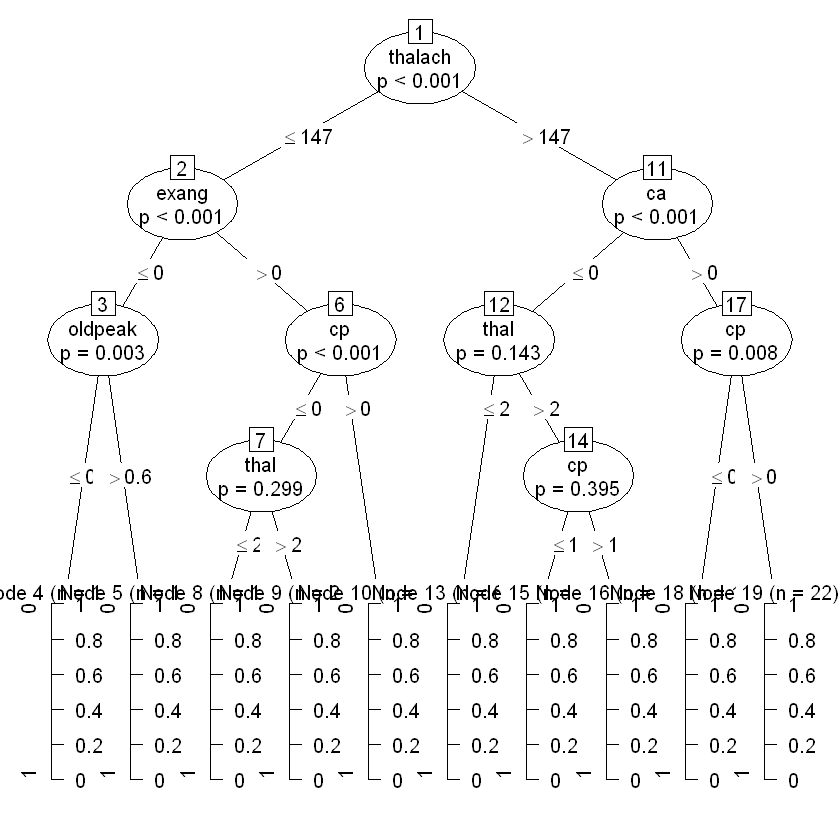

In [118]:
plot(CART_pre)

In [119]:
CART_pre_cm <- table(test$HeartYN, CART_pre_prediction)
CART_pre_cm

   CART_pre_prediction
     0  1
  0 35 14
  1 10 44

In [120]:
Perf_Table[3,] <- perf_eval(CART_pre_cm)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
CART(pruned(x)),0.8333333,0.7894737,0.7551020,0.7961165,0.7932539,0.8108108
CART(pruned(post)),0.9444444,0.7611940,0.6734694,0.8155340,0.7975302,0.8429752
CART(pruned(pre)),0.8148148,0.7586207,0.7142857,0.7669903,0.7628962,0.7857143


# [Q3] 



In [121]:
Perf_Table_2 <- matrix(0,nrow=4,ncol=6)
rownames(Perf_Table_2) <- c("tree","rpart","c50","random_forest")
colnames(Perf_Table_2) <- c("TPR", "Precision", "TNR", "Accuracy", "BCR", "F1-Measure")
Perf_Table_2[1,] <- perf_eval(CART_cfm)
Perf_Table_2

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
tree,0.9444444,0.761194,0.6734694,0.815534,0.7975302,0.8429752
rpart,0.0000000,0.000000,0.0000000,0.000000,0.0000000,0.0000000
c50,0.0000000,0.000000,0.0000000,0.000000,0.0000000,0.0000000
random_forest,0.0000000,0.000000,0.0000000,0.000000,0.0000000,0.0000000


# rpart

In [122]:
install.packages("rpart")
install.packages("rpart.plot")
library(rpart)
library(rpart.plot)

Warning message:
"package 'rpart' is in use and will not be installed"
Warning message:
"package 'rpart.plot' is in use and will not be installed"


In [123]:
rpart_trn <- CART_trn
rpart_val <- CART_val

In [124]:
max_depth <- c(3,5,10)
min_split <- c(2,5,20,50)
rpart_pre_search_result = matrix(0,length(min_split)*length(max_depth),8)
colnames(rpart_pre_search_result) <- c("min_split", "max_depth", "TPR", "Precision", "TNR", "ACC", "BCR", "F1")

In [125]:
iter_cnt = 1
for ( i in 1:length(min_split)){
    for ( j in 1:length(max_depth)){
        tmp_control <- rpart.control(maxdepth = max_depth[j], minsplit = min_split[i])
        tmp_rpart_model <- rpart(HeartYN ~ ., data = rpart_trn, method = "class",control = tmp_control)
        tmp_pred <- predict(tmp_rpart_model, rpart_val, type='class')
        tmp_rpart_val_cm <- table(rpart_val$HeartYN, tmp_pred)
        rpart_pre_search_result[iter_cnt,3:8] = perf_eval(tmp_rpart_val_cm)
        rpart_pre_search_result[iter_cnt,1] = min_split[i]
        rpart_pre_search_result[iter_cnt,2] = max_depth[j]
        
        iter_cnt = iter_cnt+1

    }
}


In [126]:
rpart_pre_search_result

min_split,max_depth,TPR,Precision,TNR,ACC,BCR,F1
2,3,0.8043478,0.8409091,0.7941176,0.8000,0.7992164,0.8222222
2,5,0.8043478,0.7115385,0.5588235,0.7000,0.6704390,0.7551020
2,10,0.8043478,0.7115385,0.5588235,0.7000,0.6704390,0.7551020
5,3,0.8043478,0.8409091,0.7941176,0.8000,0.7992164,0.8222222
5,5,0.7826087,0.7058824,0.5588235,0.6875,0.6613170,0.7422680
5,10,0.7826087,0.7058824,0.5588235,0.6875,0.6613170,0.7422680
20,3,0.8260870,0.7450980,0.6176471,0.7375,0.7143040,0.7835052
20,5,0.8260870,0.7450980,0.6176471,0.7375,0.7143040,0.7835052
20,10,0.8260870,0.7450980,0.6176471,0.7375,0.7143040,0.7835052
50,3,0.9130435,0.7241379,0.5294118,0.7500,0.6952524,0.8076923


In [127]:
best_split <- rpart_pre_search_result[10,1]
best_depth <- rpart_pre_search_result[10,2]
rpart_control <- rpart.control(maxdepth = best_depth, minsplit = best_split)
rpart_model <- rpart(HeartYN ~ ., data = train, control = rpart_control, method = "class")

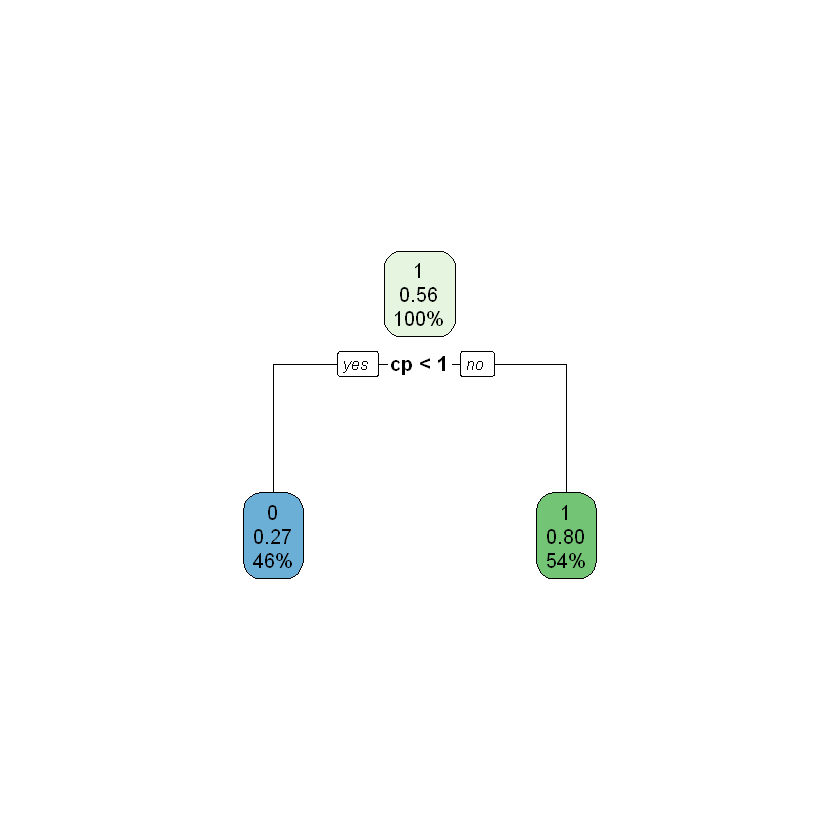

In [128]:
rpart.plot(rpart_model)

In [129]:
rpart_pred <- predict(rpart_model, test, type='class')
rpart_cm <- table(test$HeartYN, rpart_pred)
Perf_Table_2[2,] <- perf_eval(rpart_cm)
Perf_Table_2

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
tree,0.9444444,0.761194,0.6734694,0.8155340,0.7975302,0.8429752
rpart,0.7407407,0.754717,0.7346939,0.7378641,0.7377111,0.7476636
c50,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000
random_forest,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000


# C50

In [130]:
install.packages("C50")
library(C50)

Warning message:
"package 'C50' is in use and will not be installed"


In [131]:
c50_trn <- CART_trn
c50_val <- CART_val

In [132]:
confidence <- c(0.1,0.25,0.35,0.45) # default 0.25
min_cases <- c(2, 5, 10) # default 2
c50_pre_search_result = matrix(0,length(min_split)*length(max_depth),8)
colnames(c50_pre_search_result) <- c("confidence", "min_cases", "TPR", "Precision", "TNR", "ACC", "BCR", "F1")

In [133]:
iter_cnt = 1
for ( i in 1:length(confidence)){
    for ( j in 1:length(min_cases)){
        tmp_control <- C5.0Control(CF = confidence[i], minCases = min_cases[j])
        tmp_c50_model <- C5.0(HeartYN ~ ., data = c50_trn, method = "class",control = tmp_control)
        tmp_pred <- predict(tmp_c50_model, c50_val, type='class')
        tmp_c50_val_cm <- table(c50_val$HeartYN, tmp_pred)
        c50_pre_search_result[iter_cnt,3:8] = perf_eval(tmp_c50_val_cm)
        c50_pre_search_result[iter_cnt,1] = confidence[i]
        c50_pre_search_result[iter_cnt,2] = min_cases[j]
        
        iter_cnt = iter_cnt+1

    }
}

In [134]:
c50_pre_search_result

confidence,min_cases,TPR,Precision,TNR,ACC,BCR,F1
0.10,2,0.8260870,0.7450980,0.6176471,0.7375,0.7143040,0.7835052
0.10,5,0.8478261,0.7500000,0.6176471,0.7500,0.7236417,0.7959184
0.10,10,0.8478261,0.7500000,0.6176471,0.7500,0.7236417,0.7959184
0.25,2,0.7391304,0.8292683,0.7941176,0.7625,0.7661309,0.7816092
0.25,5,0.7826087,0.8780488,0.8529412,0.8125,0.8170185,0.8275862
0.25,10,0.8478261,0.7500000,0.6176471,0.7500,0.7236417,0.7959184
0.35,2,0.7391304,0.8500000,0.8235294,0.7750,0.7801895,0.7906977
0.35,5,0.7826087,0.8780488,0.8529412,0.8125,0.8170185,0.8275862
0.35,10,0.8478261,0.7500000,0.6176471,0.7500,0.7236417,0.7959184
0.45,2,0.7391304,0.8500000,0.8235294,0.7750,0.7801895,0.7906977


In [135]:
best_cf <- c50_pre_search_result[12,1]
best_mincases <- c50_pre_search_result[12,2]
c50_control <- C5.0Control(CF = best_cf, minCases = best_mincases)
c50_model <- C5.0(HeartYN ~ ., data = train, method = "class",control = c50_control)

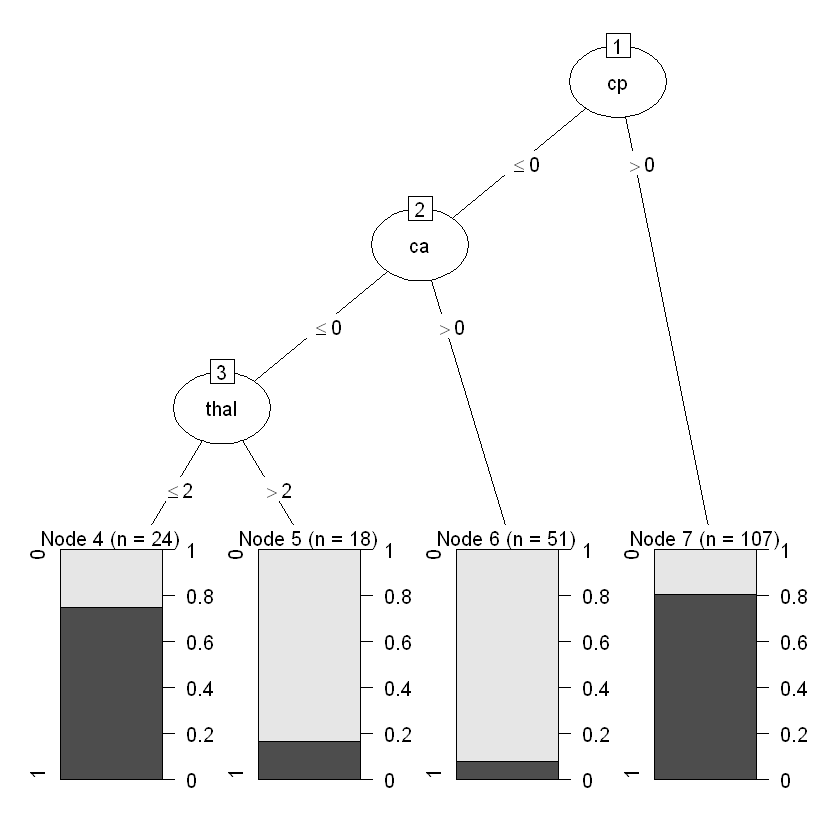

In [136]:
plot(c50_model)

In [137]:
c50_pred <- predict(c50_model, test, type='class')
c50_cm <- table(test$HeartYN, c50_pred)
Perf_Table_2[3,] <- perf_eval(c50_cm)
Perf_Table_2

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
tree,0.9444444,0.761194,0.6734694,0.8155340,0.7975302,0.8429752
rpart,0.7407407,0.754717,0.7346939,0.7378641,0.7377111,0.7476636
c50,0.9444444,0.761194,0.6734694,0.8155340,0.7975302,0.8429752
random_forest,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000


# randomForest

In [138]:
install.packages("randomForest")
library(randomForest)

Warning message:
"package 'randomForest' is in use and will not be installed"


In [139]:
rf_trn <- CART_trn
rf_val <- CART_val

In [140]:
ntree <- c(50, 100, 150) 
mtry <- c(floor(sqrt(ncol(train))),floor(sqrt(ncol(train)))*2,floor(sqrt(ncol(train)))*3)
rf_pre_search_result = matrix(0,length(ntree)*length(mtry),8)
colnames(rf_pre_search_result) <- c("ntree", "mtry", "TPR", "Precision", "TNR", "ACC", "BCR", "F1")

In [141]:
iter_cnt = 1
for ( i in 1:length(ntree)){
    for ( j in 1:length(mtry)){
        tmp_rf_model <-randomForest(HeartYN ~ ., data=rf_trn, mtry = mtry[j], ntree = ntree[i], importance = T)
        tmp_pred <- predict(tmp_rf_model, rf_val)
        tmp_rf_val_cm <- table(rf_val$HeartYN, tmp_pred)
        rf_pre_search_result[iter_cnt,3:8] = perf_eval(tmp_rf_val_cm)
        rf_pre_search_result[iter_cnt,1] = ntree[i]
        rf_pre_search_result[iter_cnt,2] = mtry[j]
        
        iter_cnt = iter_cnt+1

    }
}

In [142]:
rf_pre_search_result

ntree,mtry,TPR,Precision,TNR,ACC,BCR,F1
50,3,0.8478261,0.8666667,0.8235294,0.8375,0.8355894,0.8571429
50,6,0.8478261,0.8478261,0.7941176,0.8250,0.8205325,0.8478261
50,9,0.8478261,0.8478261,0.7941176,0.8250,0.8205325,0.8478261
100,3,0.8478261,0.8125000,0.7352941,0.8000,0.7895578,0.8297872
100,6,0.8478261,0.8478261,0.7941176,0.8250,0.8205325,0.8478261
100,9,0.8478261,0.8666667,0.8235294,0.8375,0.8355894,0.8571429
150,3,0.8478261,0.8297872,0.7647059,0.8125,0.8051941,0.8387097
150,6,0.8478261,0.8297872,0.7647059,0.8125,0.8051941,0.8387097
150,9,0.8478261,0.8478261,0.7941176,0.8250,0.8205325,0.8478261


In [143]:
best_ntree <- rf_pre_search_result[1,1]
best_mtry <- rf_pre_search_result[1,2]
rf_model <-randomForest(HeartYN ~ ., data=train, mtry = best_mtry, ntree = best_ntree, importance = T)

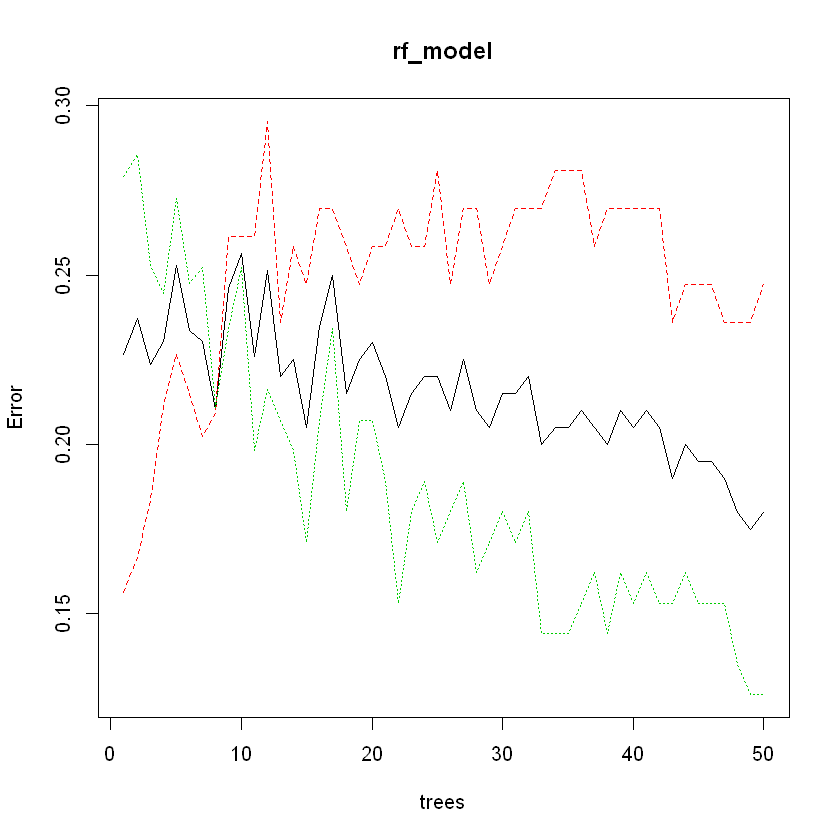

In [144]:
plot(rf_model)

In [145]:
getConds<-function(tree){
  #store all conditions into a list
  conds<-list()
  #start by the terminal nodes and find previous conditions
  id.leafs<-which(tree$status==-1)
	  j<-0
	  for(i in id.leafs){
		j<-j+1
		prevConds<-prevCond(tree,i)
		conds[[j]]<-prevConds$cond
		while(prevConds$id>1){
		  prevConds<-prevCond(tree,prevConds$id)
		  conds[[j]]<-paste(conds[[j]]," & ",prevConds$cond)
        }
		if(prevConds$id==1){
			conds[[j]]<-paste(conds[[j]]," => ",tree$prediction[i])
        }
    }


  return(conds)
}

#**************************
#find the previous conditions in the tree
#**************************
prevCond<-function(tree,i){
  if(i %in% tree$right_daughter){
		id<-which(tree$right_daughter==i)
		cond<-paste(tree$split_var[id],">",tree$split_point[id])
	  }
	  if(i %in% tree$left_daughter){
    id<-which(tree$left_daughter==i)
		cond<-paste(tree$split_var[id],"<",tree$split_point[id])
  }

  return(list(cond=cond,id=id))
}

#remove spaces in a word
collapse<-function(x){
  x<-sub(" ","_",x)

  return(x)
}
tree<-getTree(rf_model, k=1, labelVar=TRUE)
#rename the name of the column
colnames(tree)<-sapply(colnames(tree),collapse)
rules<-getConds(tree)
print(rules)

[[1]]
[1] "age < 54.5  &  sex < 0.5  &  thal < 2.5  =>  1"

[[2]]
[1] "age < 49.5  &  oldpeak < 0.7  &  thal > 2.5  =>  0"

[[3]]
[1] "age > 63.5  &  age > 54.5  &  sex < 0.5  &  thal < 2.5  =>  1"

[[4]]
[1] "age < 60.5  &  fbs > 0.5  &  sex > 0.5  &  thal < 2.5  =>  0"

[[5]]
[1] "cp > 0.5  &  age > 49.5  &  oldpeak < 0.7  &  thal > 2.5  =>  1"

[[6]]
[1] "age < 38.5  &  age < 42.5  &  oldpeak > 0.7  &  thal > 2.5  =>  0"

[[7]]
[1] "age > 38.5  &  age < 42.5  &  oldpeak > 0.7  &  thal > 2.5  =>  1"

[[8]]
[1] "ca > 0.5  &  age > 42.5  &  oldpeak > 0.7  &  thal > 2.5  =>  0"

[[9]]
[1] "oldpeak < 0.7  &  age > 60.5  &  fbs > 0.5  &  sex > 0.5  &  thal < 2.5  =>  1"

[[10]]
[1] "ca > 0.5  &  cp < 0.5  &  age > 49.5  &  oldpeak < 0.7  &  thal > 2.5  =>  0"

[[11]]
[1] "cp < 1  &  ca < 0.5  &  age > 42.5  &  oldpeak > 0.7  &  thal > 2.5  =>  0"

[[12]]
[1] "exang > 0.5  &  slope < 1.5  &  age < 63.5  &  age > 54.5  &  sex < 0.5  &  thal < 2.5  =>  0"

[[13]]
[1] "trestbps < 129  &  slop

In [146]:
rf_pred <- predict(rf_model, test, type='class')
rf_cm <- table(test$HeartYN, rf_pred)
Perf_Table_2[4,] <- perf_eval(rf_cm)
Perf_Table_2

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
tree,0.9444444,0.7611940,0.6734694,0.8155340,0.7975302,0.8429752
rpart,0.7407407,0.7547170,0.7346939,0.7378641,0.7377111,0.7476636
c50,0.9444444,0.7611940,0.6734694,0.8155340,0.7975302,0.8429752
random_forest,0.8888889,0.7619048,0.6938776,0.7961165,0.7853535,0.8205128
